In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchtext
import json
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time
import sys
sys.path.append('../../')

from utils import *

<h1>3-2. ELMo<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Prepare-dataset:-IMBD" data-toc-modified-id="Prepare-dataset:-IMBD-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Prepare dataset: IMBD</a></span><ul class="toc-item"><li><span><a href="#For-pretraining" data-toc-modified-id="For-pretraining-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>For pretraining</a></span></li></ul></li><li><span><a href="#Build-the-model" data-toc-modified-id="Build-the-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Build the model</a></span><ul class="toc-item"><li><span><a href="#Bidirectional-language-model" data-toc-modified-id="Bidirectional-language-model-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Bidirectional language model</a></span></li><li><span><a href="#ELMo" data-toc-modified-id="ELMo-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>ELMo</a></span></li></ul></li><li><span><a href="#Train-the-model" data-toc-modified-id="Train-the-model-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Train the model</a></span><ul class="toc-item"><li><span><a href="#Pretrain-bidirectional-language-model" data-toc-modified-id="Pretrain-bidirectional-language-model-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Pretrain bidirectional language model</a></span><ul class="toc-item"><li><span><a href="#Intermediate-results" data-toc-modified-id="Intermediate-results-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Intermediate results</a></span></li></ul></li><li><span><a href="#Train-ELMo-for-sentiment-analysis" data-toc-modified-id="Train-ELMo-for-sentiment-analysis-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Train ELMo for sentiment analysis</a></span></li></ul></li></ul></div>

## Prepare dataset: IMBD

In [2]:
from torchtext.experimental.datasets import IMDB
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("spacy")
train, test = IMDB(tokenizer=tokenizer, root="../torchdata/")

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [01:45<00:00, 799kB/s] 
100%|██████████| 25000/25000 [00:24<00:00, 1023.84lines/s]


In [3]:
from collections import Counter

vocab = train.get_vocab()

v = Counter(['<s>', '</s>'])
v = torchtext.vocab.Vocab(v, specials=['<s>', '</s>'])
vocab.extend(v)

In [4]:
VOCAB_SIZE = len(vocab)
ngrams = 2

```python
ngrams = 2
bos = "<s>"
eos = "</s>"

x = []
y = []
for _, words in tqdm(train):
    # Begin-of-sentence token
    x.append([vocab.stoi[bos]] + words[0:ngrams-1].tolist())
    y.append(words[ngrams-1].item())
    
    # in-sentence tokens
    for i in range(len(words)-ngrams):
        text = words[i:i+ngrams]
        label = words[i+ngrams]
        x.append(text.tolist())
        y.append(label.tolist())
        
    # End-of-sentence token
    x.append(words[i+1:i+ngrams].tolist() + [vocab.stoi[eos]])
    y.append(vocab.stoi[eos])
```

```python
with open("./IMBD_bigram.json", "w") as w:
    json.dump({"data": x, "label": y}, w)
```

In [5]:
with open("./IMBD_bigram.json") as r:
    xy = json.load(r)

### For pretraining

* transform to character-level n-gram dataset
    * original script
```
%load https://gist.githubusercontent.com/akurniawan/30719686669dced49e7ced720329a616/raw/7b9f9967c01ce87ac505520a5aa58d3b24c55c66/translation_char_example.py
```
    * modified
```
%load https://gist.github.com/naturale0/6bb3b8a5c682bd281de87e408fa71bf1/raw/df8b7e198f149f81c4f72af977760b2eb3226cdf/translation_char_example.py
```

In [6]:
# Modified a little to fit classification
import itertools
from torchtext.experimental.datasets import TextClassificationDataset
from torchtext.vocab import build_vocab_from_iterator
from torchtext.experimental.functional import sequential_transforms

def build_char_vocab(data, index, 
                     bow="<w>", eow="</w>",
                     bos="<s>", eos="</s>"):
    """
    build character level vocabulary
    """
    tok_list = [
        [bow],
        [eow],
        [bos],
        [eos],
    ]
    for line in data:
        tokens = list(itertools.chain.from_iterable(line[index]))
        tok_list.append(tokens)
    return build_vocab_from_iterator(tok_list)


def stoi(vocab):
    """
    change string to index
    """
    def func(tok_iter):
        return [[vocab[char] for char in word]\
                for word in tok_iter]

    return func


def tokenize_char(bow="<w>", eow="</w>", 
                  bos="<s>", eos="</s>",
                  max_word_length=20):
    """
    attach bow, eow token and pad with token
    """
    def func(tok_iter):
        result = np.empty((len(tok_iter), max_word_length+2), dtype=object)
        result[:] = "<pad>"
        
        for i, word in enumerate(tok_iter):
            if "".join(word) == "<s>":
                # Begin-of-sentence token
                result[i, :3] = [bow, bos, eow] #+ ["<pad>"] * (max_word_length - 1)
            elif "".join(word) == "</s>":
                # End-of-sentence token
                result[i, :3] = [bow, eos, eow] #+ ["<pad>"] * (max_word_length - 1)
            else:
                # in-sentence words
                if len(word) < max_word_length:
                    result[i, :len(word)+2] = [bow] + word + [eow]
                else:
                    result[i, :] = [bow] + word[:max_word_length] + [eow]
                
                
#                 result[:len(tok_iter)] = [
#                     [bow] + word + [eow] \
#                     + ["<pad>"] * (max_word_length - len(word)) \
#                     if len(word) < max_word_length \
#                     else [bow] + word[:max_word_length] + [eow]
#                 for word in tok_iter]

        return result

    return func

In [7]:
x = xy["data"]
y = xy["label"]

In [8]:
# Cache training data for vocabulary construction
train_data = [([vocab.itos[ix] for ix in line[0]], line[1]) for line in tqdm(zip(x, y))]

6810715it [00:06, 1048058.83it/s]


In [9]:
train_data[:3]

[(['<s>', 'I'], 1657), (['I', 'rented'], 11), (['rented', 'I'], 14567)]

In [10]:
# Setup vocabularies (both words and chars)
char_vocab = build_char_vocab(train_data, index=0)

6810719lines [00:07, 900031.96lines/s]


In [11]:
# Building the dataset with character level tokenization
def char_tokenizer(words):
    return [list(word) for word in words]

char_transform = sequential_transforms(
    char_tokenizer, 
    tokenize_char(), 
    stoi(char_vocab),
    lambda x: torch.tensor(x)
)

trainset = TextClassificationDataset(
    train_data,
    char_vocab,
    (char_transform, lambda x: x),
)

In [12]:
print([[char_vocab.itos[i] for i in w] for w in trainset[17][0]] [1][:13])

['<w>', 's', 'u', 'r', 'r', 'o', 'u', 'n', 'd', 'e', 'd', '</w>', '<pad>']


In [17]:
# Prepare DataLoader
# def collate_fn(batch):
#     text, label = zip(*batch)
#     label = torch.LongTensor(label)
#     text = torch.stack(text)
#     #lens = list(map(lambda x: len(x[(x != 0).all(dim=1)]), text))
    
#     return text, label

pretrainloader = data.DataLoader(trainset, 
                                 batch_size=256)

In [131]:
xx, yy = next(iter(pretrainloader))

## Build the model

### Bidirectional language model

In [132]:
class CharConv(nn.Module):
    
    def __init__(self):
        super(CharConv, self).__init__()
        
        # Embedding layer
        CHAR_EMBEDDING_DIM = 16
        self.char_embedding = nn.Embedding(len(char_vocab), CHAR_EMBEDDING_DIM)
        
        # Conv layers
        self.conv1 = nn.Conv2d(CHAR_EMBEDDING_DIM, 2, 1)
        self.conv2 = nn.Conv2d(CHAR_EMBEDDING_DIM, 2, (1, 2))
        self.conv3 = nn.Conv2d(CHAR_EMBEDDING_DIM, 4, (1, 3))
        self.conv4 = nn.Conv2d(CHAR_EMBEDDING_DIM, 8, (1, 4))
        self.conv5 = nn.Conv2d(CHAR_EMBEDDING_DIM, 16, (1, 5))
        self.conv6 = nn.Conv2d(CHAR_EMBEDDING_DIM, 32, (1, 6))
        self.conv7 = nn.Conv2d(CHAR_EMBEDDING_DIM, 64, (1, 7))
        self.convs = [
            self.conv1, self.conv2, self.conv3,
            self.conv4, self.conv5, self.conv6, self.conv7,
        ]
        
    
    def forward(self, x):
        # character-level convolution
        x = self.char_embedding(x).permute(0,3,1,2)
        x = [conv(x) for conv in self.convs]
        x = [F.max_pool2d(x_c, kernel_size=(1, x_c.shape[3])) for x_c in x]
        x = [torch.squeeze(x_p, dim=3) for x_p in x]
        x = torch.hstack(x)  # 1, n_batch, concat_length
        #x = x.view(2, 0, 1)
        
        return x

In [181]:
class BiLSTM(nn.Module):
    def __init__(self):
        super(BiLSTM, self).__init__()
        # Bi-LSTM
        self.lstm1 = nn.LSTM(128, 1024, bidirectional=True)
        self.dropout = nn.Dropout(0.1)
        self.proj = nn.Linear(2*1024, 2*128, bias=False)
        self.lstm2 = nn.LSTM(2*128, 1024, bidirectional=True)
    
    def forward(self, x):
        ## reshape input
        #x = x.view(-1, 128, ngrams).permute(2, 0, 1)
        
        # 1st LSTM layer
        o, (h1, __) = self.lstm1(x)
        o = self.dropout(o)
        
        # main connection
        p = self.proj(o)
        
        # skip connection
        x2 = x.repeat(1,1,2)
        x3 = x2 + p
        
        # 2nd LSTM layer
        _, (h2, __) = self.lstm2(x3)
        return h1, h2

In [182]:
class BiLangModel(nn.Module):
    """
    Bidirectional language model (will be pretrained)
    """
    def __init__(self, char_cnn, bi_lstm):
        super(BiLangModel, self).__init__()
        
        # Highway connection
        CHAR_EMBEDDING_DIM = 16
        self.highway = nn.Linear(128, 128)
        self.transform = nn.Linear(128, 128)
        self.char_cnn = char_cnn
        self.bi_lstm = bi_lstm
        
        # last layer: classifier
        self.fc = nn.Linear(ngrams * 1024, 1024)
        
    def forward(self, x):
        # Character-level convolution
        x = self.char_cnn(x)
        x = x.permute(2, 0, 1)
        
        # highway
        h = self.highway(x)
        t_gate = torch.sigmoid(self.transform(x))
        c_gate = 1 - t_gate
        x = h * t_gate + x * c_gate
        
        # Bi-LSTM
        x1, x2 = self.bi_lstm(x)
        
        return x1, x2

In [183]:
class Pretrainer(nn.Module):
    def __init__(self, bilm, ngrams):
        super(Pretrainer, self).__init__()
        
        # last layer: classifier
        self.fc = nn.Linear(ngrams * 1024, 1024)
        self.bilm = bilm
        
    def forward(self, x):
        _, x = self.bilm(x)
        
        # fully-connected layer (classify)
        x = x.view(-1, ngrams * 1024)
        x = self.fc(x)
        
        return x

In [184]:
charconv = CharConv()
bilstm = BiLSTM()
bilm = BiLangModel(charconv, bilstm)
model = Pretrainer(bilm, ngrams)
model(xx).shape

torch.Size([256, 1024])

```python
from torchviz import make_dot

charconv = CharConv()
bilstm = BiLSTM()
bilm = BiLangModel(charconv, bilstm)

model = Pretrainer(bilm, ngrams)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000])

make_dot(criterion(model(xx), yy).loss).render("BiLanguageModel", format="png")
```

![](BiLanguageModel.png)

  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.76E-01


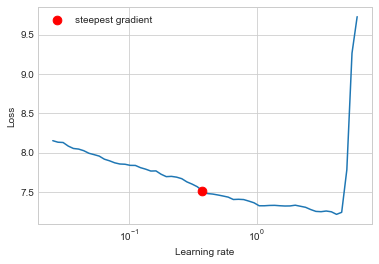

(<AxesSubplot:xlabel='Learning rate', ylabel='Loss'>, 0.37649358067924676)

In [24]:
from torch_lr_finder import LRFinder

charconv = CharConv(); bilstm = BiLSTM()
model = BiLangModel(charconv, bilstm)
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
criterion_ = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
)
criterion = lambda x, y: criterion_(x, y).loss

lr_finder = LRFinder(model, optimizer, criterion)
lr_finder.range_test(pretrainloader, end_lr=100, num_iter=100)
lr_finder.plot(log_lr=True)

### ELMo

## Train the model

### Pretrain bidirectional language model

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.3, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
).to(device)

In [28]:
charconv = CharConv()
bilstm = BiLSTM()

model = BiLangModel(charconv, bilstm).to(device)
optimizer = optim.SGD(model.parameters(), lr=0.03, momentum=0.9)
criterion = nn.AdaptiveLogSoftmaxWithLoss(
    1024, VOCAB_SIZE, cutoffs=[10, 100, 1000, 10000]
).to(device)

In [29]:
def accuracy(output, y):
    with torch.no_grad():
        pred = criterion.log_prob(output).argmax(dim=1)
    correct = (pred == y).float()
    #print(pred.shape, correct.shape)
    return correct.sum() / len(correct)

In [30]:
def train(model, dataloader, criterion, optimizer):
    loss_epoch = 0.
    acc_epoch = 0.
    for x, y in dataloader:
        model.zero_grad()
        
        x = x.to(device)
        y = y.to(device)
        
        out = model(x)
        loss = criterion(out, y).loss
        
        loss.backward()
        optimizer.step()
        
        loss_epoch += loss.item()
        acc_epoch += accuracy(out, y).item()
    return loss_epoch, acc_epoch

In [31]:
losses = []
accs = []

In [32]:
N_EPOCH = 100
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=1.,  # from LR range test plot
    epochs=N_EPOCH, 
    steps_per_epoch=len(pretrainloader)
)

In [38]:
for i in range(1, N_EPOCH+1):
    t0 = time()
    
    loss_epoch, acc_epoch = train(model, pretrainloader, criterion, optimizer)
    losses.append(loss_epoch)
    accs.append(acc_epoch)
    scheduler.step()
    
    t1 = time()
    
    if i % 1 == 0:
        print(f"epoch: {i:03}, loss: {loss_epoch/len(pretrainloader): .3f}, acc: {acc_epoch/len(pretrainloader): .4f}, {t1-t0: .1f} sec")

epoch: 001, loss:  7.200, acc:  0.0421,  984.1 sec
epoch: 002, loss:  7.196, acc:  0.0425,  982.3 sec
epoch: 003, loss:  7.194, acc:  0.0427,  983.9 sec
epoch: 004, loss:  7.193, acc:  0.0428,  984.7 sec
epoch: 005, loss:  7.192, acc:  0.0429,  982.1 sec
epoch: 006, loss:  7.191, acc:  0.0431,  983.3 sec
epoch: 007, loss:  7.190, acc:  0.0432,  984.9 sec
epoch: 008, loss:  7.189, acc:  0.0433,  983.0 sec
epoch: 009, loss:  7.188, acc:  0.0434,  984.2 sec
epoch: 010, loss:  7.186, acc:  0.0437,  982.7 sec
epoch: 011, loss:  7.183, acc:  0.0440,  987.1 sec
epoch: 012, loss:  7.179, acc:  0.0446,  981.5 sec
epoch: 013, loss:  7.174, acc:  0.0454,  984.4 sec
epoch: 014, loss:  7.168, acc:  0.0462,  984.3 sec
epoch: 015, loss:  7.162, acc:  0.0469,  983.7 sec
epoch: 016, loss:  7.163, acc:  0.0466,  983.9 sec
epoch: 017, loss:  7.154, acc:  0.0478,  984.9 sec
epoch: 018, loss:  7.147, acc:  0.0487,  988.7 sec
epoch: 019, loss:  7.142, acc:  0.0493,  983.0 sec
epoch: 020, loss:  7.138, acc: 

In [39]:
torch.save({'model_state_dict': model.state_dict(),
            'loss': losses,
            'acc': accs},
           "./ELMo-BiLM_SGD_lr0.5-2._momentum0.9_epoch25.pth")

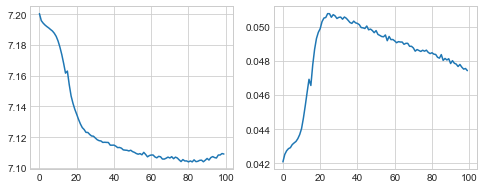

In [40]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.plot(np.array(losses) / len(pretrainloader))
plt.subplot(122)
plt.plot(np.array(accs) / len(pretrainloader))

#### Intermediate results

In [67]:
charconv = CharConv()
bilstm = BiLSTM()
model = BiLangModel(charconv, bilstm)

checkpoint = torch.load("./ELMo-BiLM_SGD_lr0.3-1._momentum0.9_epoch100.pth",
                        map_location=torch.device('cpu'))
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [68]:
#model.to(device)
model.eval();  # evaluation mode

In [77]:
N_WORDS = 150
words = list(zip(*vocab.freqs.most_common(N_WORDS)))[0]

In [108]:
with torch.no_grad():
    x1 = model.char_cnn(words_input)

In [113]:
x1.permute(0,2,1).shape

torch.Size([1, 150, 128])

In [117]:
nn.Linear(128, 1000)(x1.permute(0,2,1))

tensor([[[-0.2201, -0.6893,  0.1313,  ..., -0.0420, -0.4826,  0.0489],
         [ 0.3486, -0.2967,  0.7657,  ...,  0.3154, -0.1451,  0.3309],
         [ 0.3169, -0.8092,  0.7815,  ...,  0.3667, -0.3338,  0.5977],
         ...,
         [ 0.5004, -0.3708,  1.1143,  ..., -0.4220,  0.5668,  0.3076],
         [ 0.0768, -0.8862,  0.0696,  ...,  0.0975,  0.1715,  0.0440],
         [ 0.0929, -0.3482,  0.0198,  ..., -0.2707, -0.2820,  0.6174]]],
       grad_fn=<AddBackward0>)

In [119]:
x1.shape

torch.Size([1, 128, 150])

In [129]:
with torch.no_grad():
    x1 = model.char_cnn(words_input)
    _, (x2, __) = model.bi_lstm.lstm1(x1.permute(0,2,1))

In [130]:
x2.shape

torch.Size([2, 150, 1024])

In [104]:
with torch.no_grad():
    x1 = model.char_cnn(words_input)
    x1 = x1.view(-1, N_WORDS*128)

    # highway
    h = model.highway(x1)
    t_gate = torch.sigmoid(model.transform(x1))
    c_gate = 1 - t_gate
    x1 = h * t_gate + x1 * c_gate

    # Bi-LSTM
    _, x1 = self.bi_lstm(x1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x19200 and 256x256)

In [89]:
def embedding(words_idx):
    if isinstance(words_idx, int):
        words_idx = [words_idx]
    
    words = [vocab.itos[i] for i in words_idx]
    
    words_input = stoi(char_vocab)(tokenize_char()(char_tokenizer(words)))
    words_input = torch.tensor(words_input).view(1, len(words), -1)
    words_input = words_input
    
    with torch.no_grad():
        char_cnn = model.char_cnn
        x1 = torch.squeeze(char_cnn(words_input))
    return x1.detach().T

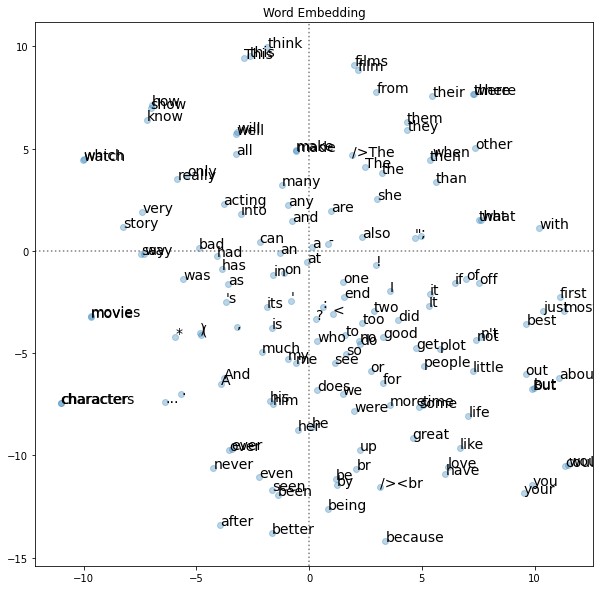

In [97]:
plot_embedding(vocab.freqs, embedding, vocab.stoi);

In [98]:
for word in ["angel", "snow", "love", "death"]:
    print(find_similar(word, vocab.freqs, embedding, vocab.stoi))

['anger', 'angle', 'Angel', 'added', 'until']
['know', 'show', 'slow', 'now', 'shadow']
['Love', 'live', 'loved', 'move', 'gave']
['Death', 'depth', 'breath', 'teeth', 'beneath']


### Train ELMo for sentiment analysis